In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tic_env import *

In [2]:
Turns = np.array(['X','O'])
player1 = DQN(epsilon=0.01, player=Turns[0])
player2 = OptimalPlayer(epsilon=0.5, player=Turns[1])
env1 = DQlearningEnv(player1=player1, player2=player2)
env1.train(20000)

Text(0, 0.5, 'avg reward')

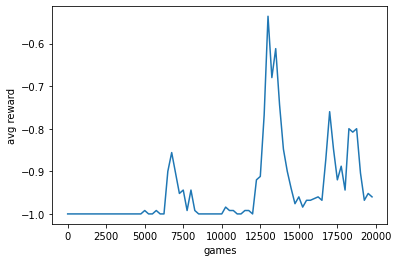

In [3]:
import matplotlib.pyplot as plt
length1=250
lst1 = env1.get_reward(player=1)
x_ticks = range(0, len(lst1), length1)
avg_reward1 = []
for i in range(len(lst1)//length1):
    avg_reward1.append(sum(lst1[i*length1:(i+1)*length1])/length1)
plt.plot(x_ticks, avg_reward1)
plt.xlabel(f'games')
plt.ylabel('avg reward')

Text(0, 0.5, 'avg loss')

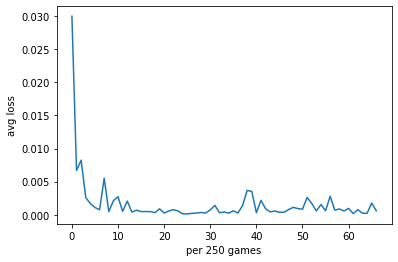

In [4]:
y_loss = env1.get_loss()
x_loss = range(0, len(y_loss))

plt.plot(x_loss, y_loss)
plt.xlabel(f'per 250 games')
plt.ylabel('avg loss')